# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import plot_image, demo_model
import numpy as np

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
# model = demo_model(preset='marmousi-elastic', data_path="/Users/mathiaslouboutin/research/London/CodeGen/data/")
model = demo_model(preset='layers-elastic', ratio=5, shape=(301, 501), spacing=(10., 10.))

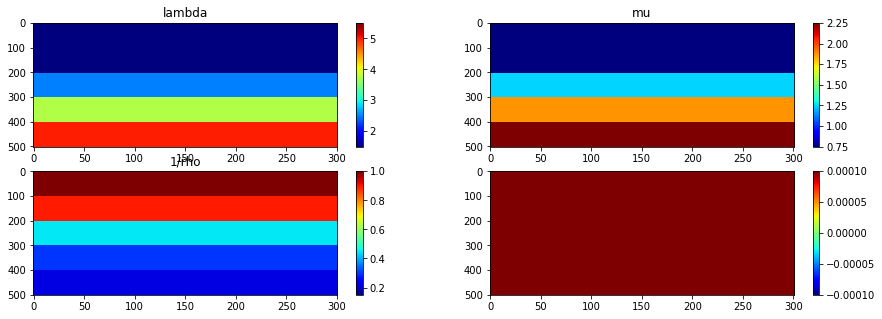

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

slices = [slice(model.nbpml, -model.nbpml), slice(model.nbpml, -model.nbpml)]

img1 = ax[0, 0].imshow(np.transpose(model.lam.data[slices]), vmin=1.5, vmax=5.5, cmap="jet")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].title.set_text('lambda')
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(model.mu.data[slices]), vmin=.75, vmax=2.25, cmap="jet")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].title.set_text('mu')
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(model.irho.data[slices]), vmin=.15, vmax=1.0, cmap="jet")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].title.set_text('1/rho')
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(model.irho.data[slices]), vmin=-0.0001, vmax=0.0001, cmap="jet")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')


In [4]:
# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 3500.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1500, 25.]

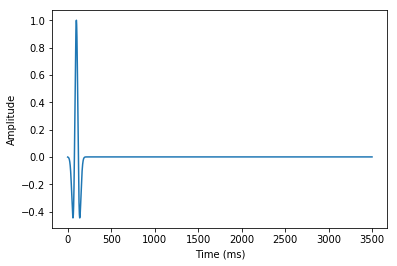

In [5]:
#NBVAL_SKIP

src.show()

In [6]:
# Now we create the velocity and pressure fields
so = 4

v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [7]:
# Now let's try and create the staggered updates
t = model.grid.stepping_dim
time = model.grid.time_dim

# The source injection term
src_xx = src.inject(field=tau.forward[0,0], expr=src)
src_zz = src.inject(field=tau.forward[1,1], expr=src)

# The receiver
nrec = 501
rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec.coordinates.data[:, -1] = 25.

rec_term = rec.interpolate(expr=tau[0, 0] + tau[1, 1])
# Thorbecke's parameter notation
l, mu, ro = model.lam, model.mu, model.irho

# fdelmodc reference implementation
u_v = Eq(v.forward, model.damp * v - model.damp*dt*ro*div(tau))
u_t = Eq(tau.forward, model.damp * tau -  model.damp*(dt * l * diag(div(v.forward)) + 
                                                      dt * mu * (grad(v.forward) + grad(v.forward).T)))

op = Operator([u_v] + src_xx + src_zz + [u_t] + rec_term)

In [8]:
#NBVAL_IGNORE_OUTPUT

op()

Operator `Kernel` run in 9.78 s


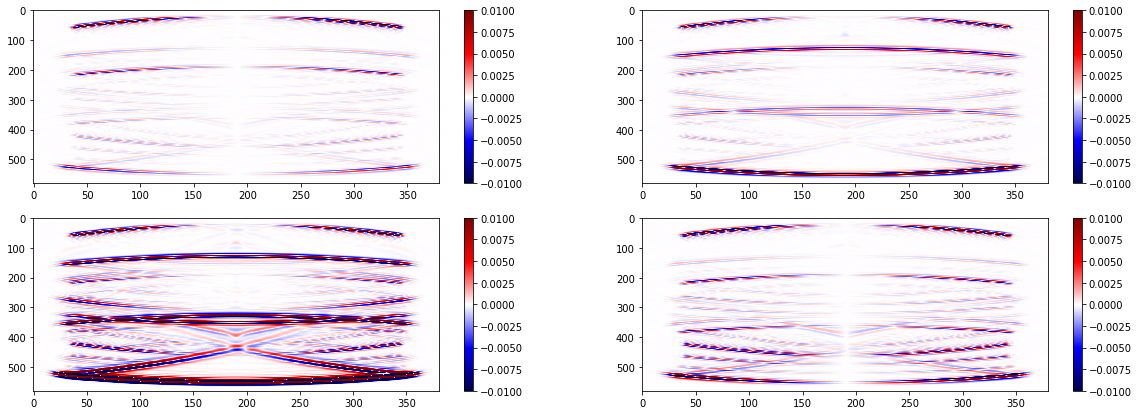

In [9]:
#NBVAL_SKIP
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 7))

img1 = ax[0, 0].imshow(np.transpose(v[0].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(v[1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(tau[0,0].data[0]+tau[1,1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(tau[0,1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')

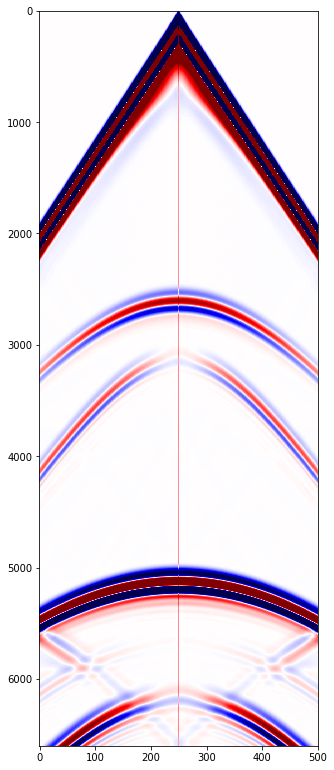

In [10]:
plt.figure(figsize=(5, 15))
plt.imshow(rec.data, vmin=-.01, vmax=.01, cmap="seismic", aspect=.2)

In [11]:
# Now that looks pretty! But let's do it again with a higher order...
so = 8
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)
# The source injection term
src_xx = src.inject(field=tau.forward[0,0], expr=src)
src_zz = src.inject(field=tau.forward[1,1], expr=src)
# fdelmodc reference implementation
u_v = Eq(v.forward, model.damp * v - model.damp*dt*ro*div(tau))
u_t = Eq(tau.forward, model.damp * tau -  model.damp*(dt * l * diag(div(v.forward)) + 
                                                      dt * mu * (grad(v.forward) + grad(v.forward).T)))

op = Operator([u_v] + src_xx + src_zz + [u_t] + rec_term)


In [12]:
#NBVAL_IGNORE_OUTPUT
v[0].data.fill(0.)
v[1].data.fill(0.)
tau[0,0].data.fill(0.)
tau[0,1].data.fill(0.)
tau[1,1].data.fill(0.)

op()

Operator `Kernel` run in 12.84 s


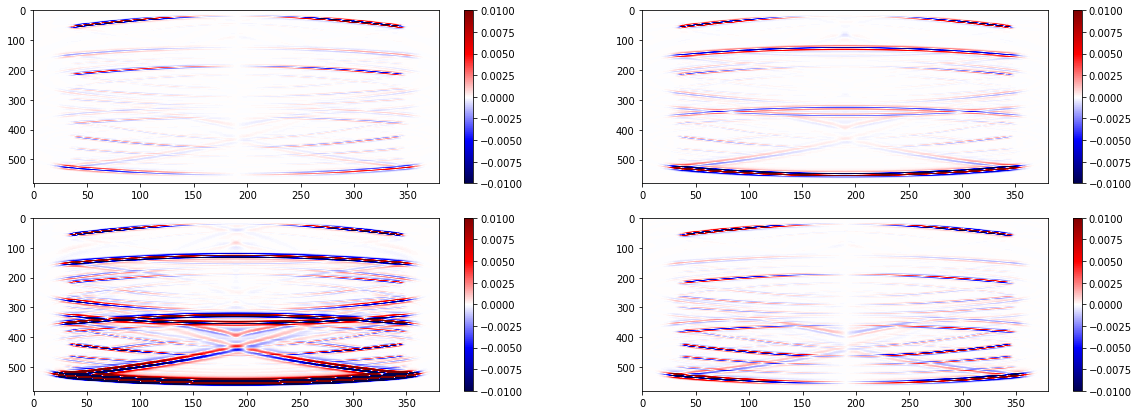

In [13]:
#NBVAL_SKIP
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 7))

img1 = ax[0, 0].imshow(np.transpose(v[0].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img1, ax=ax[0, 0])
ax[0, 0].set_aspect('auto')


img2 = ax[0, 1].imshow(np.transpose(v[1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img2, ax=ax[0, 1])
ax[0, 1].set_aspect('auto')


img3 = ax[1, 0].imshow(np.transpose(tau[0,0].data[0]+tau[1,1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img3, ax=ax[1, 0])
ax[1, 0].set_aspect('auto')

img4 = ax[1, 1].imshow(np.transpose(tau[0,1].data[0]), vmin=-1e-2, vmax=1e-2, cmap="seismic")
fig.colorbar(img4, ax=ax[1, 1])
ax[1, 1].set_aspect('auto')

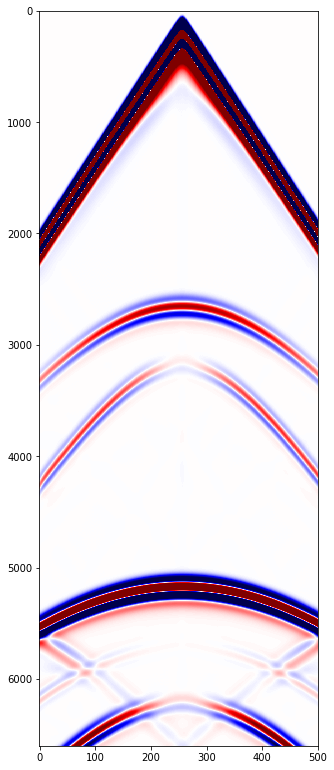

In [14]:
plt.figure(figsize=(5, 15))
plt.imshow(rec.data, vmin=-.01, vmax=.01, cmap="seismic", aspect=.2)